In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


[Introduction](introyt1_tutorial.html) ||
[Tensors](tensors_deeper_tutorial.html) ||
[Autograd](autogradyt_tutorial.html) ||
[Building Models](modelsyt_tutorial.html) ||
[TensorBoard Support](tensorboardyt_tutorial.html) ||
**Training Models** ||
[Model Understanding](captumyt.html)

# Training with PyTorch

Follow along with the video below or on [youtube](https://www.youtube.com/watch?v=jF43_wj_DCQ)_.

.. raw:: html

   <div style="margin-top:10px; margin-bottom:10px;">
     <iframe width="560" height="315" src="https://www.youtube.com/embed/jF43_wj_DCQ" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
   </div>

## Introduction

In past videos, we’ve discussed and demonstrated:

- Building models with the neural network layers and functions of the torch.nn module
- The mechanics of automated gradient computation, which is central to
  gradient-based model training
- Using TensorBoard to visualize training progress and other activities

In this video, we’ll be adding some new tools to your inventory:

- We’ll get familiar with the dataset and dataloader abstractions, and how
  they ease the process of feeding data to your model during a training loop
- We’ll discuss specific loss functions and when to use them
- We’ll look at PyTorch optimizers, which implement algorithms to adjust
  model weights based on the outcome of a loss function

Finally, we’ll pull all of these together and see a full PyTorch
training loop in action.


## Dataset and DataLoader

The ``Dataset`` and ``DataLoader`` classes encapsulate the process of
pulling your data from storage and exposing it to your training loop in
batches.

The ``Dataset`` is responsible for accessing and processing single
instances of data.

The ``DataLoader`` pulls instances of data from the ``Dataset`` (either
automatically or with a sampler that you define), collects them in
batches, and returns them for consumption by your training loop. The
``DataLoader`` works with all kinds of datasets, regardless of the type
of data they contain.

For this tutorial, we’ll be using the Fashion-MNIST dataset provided by
TorchVision. We use ``torchvision.transforms.Normalize()`` to
zero-center and normalize the distribution of the image tile content,
and download both training and validation data splits.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 26421880/26421880 [00:02<00:00, 11859208.40it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204622.68it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3701861.47it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6296960.34it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


As always, let’s visualize the data as a sanity check:




Shirt  Pullover  Dress  Sandal


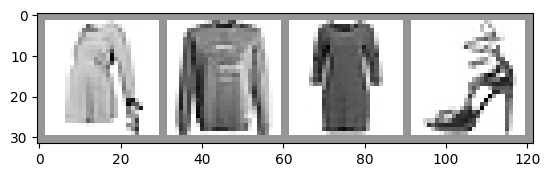

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

## The Model

The model we’ll use in this example is a variant of LeNet-5 - it should
be familiar if you’ve watched the previous videos in this series.




In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

## Loss Function

For this example, we’ll be using a cross-entropy loss. For demonstration
purposes, we’ll create batches of dummy output and label values, run
them through the loss function, and examine the result.




In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.7604, 0.1472, 0.9480, 0.8149, 0.5351, 0.1794, 0.2094, 0.4800, 0.2934,
         0.4981],
        [0.9848, 0.2038, 0.1311, 0.6688, 0.5548, 0.7559, 0.6738, 0.5627, 0.8330,
         0.3182],
        [0.5982, 0.8015, 0.1353, 0.6472, 0.2095, 0.3052, 0.1160, 0.5713, 0.1464,
         0.1558],
        [0.6378, 0.6427, 0.5564, 0.0261, 0.1867, 0.2539, 0.7345, 0.9062, 0.6812,
         0.0384]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.1969432830810547


## Optimizer

For this example, we’ll be using simple [stochastic gradient
descent](https://pytorch.org/docs/stable/optim.html)_ with momentum.

It can be instructive to try some variations on this optimization
scheme:

- Learning rate determines the size of the steps the optimizer
  takes. What does a different learning rate do to the your training
  results, in terms of accuracy and convergence time?
- Momentum nudges the optimizer in the direction of strongest gradient over
  multiple steps. What does changing this value do to your results?
- Try some different optimization algorithms, such as averaged SGD, Adagrad, or
  Adam. How do your results differ?




In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## The Training Loop

Basic Strcuture of Training Loop:
1. Forward Pass
2. Compute Loss
3. Backprop
4. Update Gradients

Below, we have a function that performs one training epoch. It
enumerates data from the DataLoader, and on each pass of the loop does
the following:

- Gets a batch of training data from the DataLoader
- Zeros the optimizer’s gradients
- Performs an inference - that is, gets predictions from the model for an input batch
- Calculates the loss for that set of predictions vs. the labels on the dataset
- Calculates the backward gradients over the learning weights
- Tells the optimizer to perform one learning step - that is, adjust the model’s
  learning weights based on the observed gradients for this batch, according to the
  optimization algorithm we chose
- It reports on the loss for every 1000 batches.
- Finally, it reports the average per-batch loss for the last
  1000 batches, for comparison with a validation run

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Per-Epoch Activity

There are a couple of things we’ll want to do once per epoch:

- Perform validation by checking our relative loss on a set of data that was not
  used for training, and report this
- Save a copy of the model

Here, we’ll do our reporting in TensorBoard. This will require going to
the command line to start TensorBoard, and opening it in another browser
tab.




In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.913488295584917
  batch 2000 loss: 0.8624016126766801
  batch 3000 loss: 0.7181801581969485
  batch 4000 loss: 0.6629665303919464
  batch 5000 loss: 0.5766087478972041
  batch 6000 loss: 0.5946087592300028
  batch 7000 loss: 0.5514831601597835
  batch 8000 loss: 0.5523427995835664
  batch 9000 loss: 0.5286849540960975
  batch 10000 loss: 0.4911040255073458
  batch 11000 loss: 0.48457202874997163
  batch 12000 loss: 0.4768406545589678
  batch 13000 loss: 0.4597095717432676
  batch 14000 loss: 0.4481050668252865
  batch 15000 loss: 0.458668195448583
LOSS train 0.458668195448583 valid 0.4334159791469574
EPOCH 2:
  batch 1000 loss: 0.41549847766652237
  batch 2000 loss: 0.43283820496709086
  batch 3000 loss: 0.416872202815488
  batch 4000 loss: 0.3971898249628721
  batch 5000 loss: 0.4017098819911917
  batch 6000 loss: 0.4141102443793789
  batch 7000 loss: 0.3958982159458974
  batch 8000 loss: 0.3881867281425512
  batch 9000 loss: 0.3883501681509224
  batch 10

To load a saved version of the model:

.. code:: python

    saved_model = GarmentClassifier()
    saved_model.load_state_dict(torch.load(PATH))

Once you’ve loaded the model, it’s ready for whatever you need it for -
more training, inference, or analysis.

Note that if your model has constructor parameters that affect model
structure, you’ll need to provide them and configure the model
identically to the state in which it was saved.

## Other Resources

-  Docs on the [data
   utilities](https://pytorch.org/docs/stable/data.html)_, including
   Dataset and DataLoader, at pytorch.org
-  A [note on the use of pinned
   memory](https://pytorch.org/docs/stable/notes/cuda.html#cuda-memory-pinning)_
   for GPU training
-  Documentation on the datasets available in
   [TorchVision](https://pytorch.org/vision/stable/datasets.html)_,
   [TorchText](https://pytorch.org/text/stable/datasets.html)_, and
   [TorchAudio](https://pytorch.org/audio/stable/datasets.html)_
-  Documentation on the [loss
   functions](https://pytorch.org/docs/stable/nn.html#loss-functions)_
   available in PyTorch
-  Documentation on the [torch.optim
   package](https://pytorch.org/docs/stable/optim.html)_, which
   includes optimizers and related tools, such as learning rate
   scheduling
-  A detailed [tutorial on saving and loading
   models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)_
-  The [Tutorials section of
   pytorch.org](https://pytorch.org/tutorials/)_ contains tutorials on
   a broad variety of training tasks, including classification in
   different domains, generative adversarial networks, reinforcement
   learning, and more




# Experiment Tracking
Why it Matters
- Reproducibility: Re-run successful experiments and understand "why" they worked.
- Comparison & Analysis: Easily compare runs, identify trends, and find the best configuration.
- Collaboration & Sharing: Centralized platform for sharing findings and tracking progress.
- Efficiency & Time-Saving: Avoid manual data entry and lost information.

> Experiment tracking is crucial for *learning from your experiments* and building better ML/DL models.

#### Main Ideas

- You want to track your values and keep record of your configurations
- You tell **what** to track
- You may also need to inform **when** to track

### Functions to look out for!
1. `wandb.log` - The main logger!!
2. `wandb.config`- Config Structure for model. Track independant non-changing parameters
2. `wandb.init` - init your project tracking!
2. `wandb.watch` - Track you model parameters: Weights and Biases
3. `wandb.sweep` - Model Optimization - Find the best hyperparameter
4. `wandb.Image`, `wandb.Video`, `Table`, .... etc. [Check](https://docs.wandb.ai/guides/track/log/media)

Input is usually:
*Data structure* - `dict` or `YAML`
(*Key:Value* :-  `{'name': value}`)



Resources:
- https://docs.wandb.ai/guides/track/log

In [ ]:
!pip install wandb
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 15.0 MB/s eta 0:00:00


In [ ]:
import wandb
from pprint import pprint
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

`wandb.run`: Each run is an experiment!

In [ ]:
# Initialize a new wandb experiment
run = wandb.init(project="CV-Tutorial")# , entity="your-username")

wandb: Currently logged in as: khan_itachi. Use `wandb login --relogin` to force relogin


In [ ]:
# Log hyperparameters
wandb.config.learning_rate =  0.001 # what to track
wandb.config.batch_size =  128 # what to track
wandb.config.epoch = 10

In [ ]:
pprint(wandb.config)

{'learning_rate': 0.001, 'batch_size': 128, 'epoch': 10}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pprint(device)

device(type='cuda')


In [ ]:
# Define the model using nn.Sequential
model = nn.Sequential(
    nn.Conv2d(1,  6,  5),
    nn.ReLU(),
    nn.MaxPool2d(2,  2),
    nn.Conv2d(6,  16,  5),
    nn.ReLU(),
    nn.MaxPool2d(2,  2),
    nn.Flatten(),  # Assuming Flatten is a custom class that flattens the tensor
    nn.Linear(16 *  4 *  4,  120),
    nn.ReLU(),
    nn.Linear(120,  84),
    nn.ReLU(),
    nn.Linear(84,  10)
)

model.to(device)

# Track Model Params
wandb.watch(model, log='all')
# https://docs.wandb.ai/ref/python/watch


criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=wandb.config.learning_rate)


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=wandb.config.batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=wandb.config.batch_size, shuffle=False)

In [ ]:
from torchmetrics import Accuracy, Precision, Recall, F1Score

# Initialize metrics
num_classes = len(classes)
accuracy = Accuracy(task='multiclass',num_classes=num_classes).to(device)
precision = Precision(task='multiclass', average='macro', num_classes=num_classes).to(device)
recall = Recall(task='multiclass', average='macro', num_classes=num_classes).to(device)
f1 = F1Score(task='multiclass', average='macro', num_classes=num_classes).to(device)

In [ ]:
# Training loop
for epoch in range(wandb.config.epoch):  # Number of epochs
    correct = 0
    total = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device) # Move to GPU

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)   # Calculate the loss

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log metrics
        wandb.log({"loss": loss.item()}) # what + when to track


    # Validation loop
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Calculate metrics
            preds = torch.argmax(model(inputs), dim=1)
            accuracy(preds, labels)
            precision(preds, labels)
            recall(preds, labels)
            f1(preds, labels)
            wandb.log({"accuracy": accuracy.compute(), "precision": precision.compute(), "recall": recall.compute(), "f1": f1.compute()})

            # Reset metrics
            accuracy.reset()
            precision.reset()
            recall.reset()
            f1.reset()

In [ ]:
# exort to ONNX and save in Netron for Vizualization
wandb.save("model.pth")

# Finish the run
run.finish()

Take a look at all the functions here: https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb

## Wandb Sweeps

#### What is it?
- Automated hyperparameter search tool for machine learning.
- Efficiently test hyperparameter combinations to find the best-performing configuration.

#### Key benefits:
- Efficient: Explore large search spaces systematically.
- Organized: Track and compare results from all configurations.
- Scalable: Run sweeps across multiple machines for faster exploration.

### Steps:
- Define search space: Specify hyperparameters and their possible values. E.g. See `sweep_config`
- Choose search method: Grid search, random search, Bayesian optimization (provided by W&B).
- Initiate the sweep using `wandb.sweep()`. Shares search space and strategy to controller.
- Run the sweep: Launch the sweep to evaluate different hyperparameter combinations. `wandb.agent()` is the main runner. It takes a `train` function.  
- Analyze results: Track metrics and visualize performance to identify the optimal configuration.

#### Additional points:
- Sweep controllers: Run sweeps locally or on the cloud (W&B offers options). Controls all experiments and sends config values to individual machines.
- Integrated with experiment tracking: Comprehensive analysis within W&B.

Resources:
- Tune hyperparameters: https://docs.wandb.ai/guides/sweeps

## Key Point!!
- We need to make sure we have a `train` callable which we can pass to `wandb.agent()`
- This `train` callable must have whatever might be needed for a training loop. Remember: we can run multiple experiments on different devices with the same `sweep_id`.

In [ ]:
def create_model(dropout):
    # Define your model architecture here
    model = nn.Sequential(
    nn.Conv2d(1,  6,  5),
    nn.ReLU(),
    nn.MaxPool2d(2,  2),
    nn.Dropout2d(dropout),
    nn.Conv2d(6,  16,  5),
    nn.ReLU(),
    nn.MaxPool2d(2,  2),
    nn.Dropout2d(dropout),
    nn.Flatten(),
    nn.Linear(16 *  4 *  4,  120),
    nn.ReLU(),
    nn.Linear(120,  84),
    nn.ReLU(),
    nn.Linear(84,  10)
    )

    return model

In [ ]:
def build_optimizer(model, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(model.parameters(),
                               lr=learning_rate)
    return optimizer


def train_epoch(model, training_loader, optimizer, device="cuda"):
    cumu_loss = 0
    criterion = nn.CrossEntropyLoss()
    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device) # Move to GPU
        optimizer.zero_grad()

        # ➡ Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        cumu_loss += loss.item()

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch loss": loss.item()})

    return cumu_loss / len(training_loader)

def get_loader(batch_size):
    training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
    return torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)


In [ ]:
def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        loader = get_loader(config.batch_size)
        model = create_model(config.dropout)
        model.to(device)
        optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(model, loader, optimizer, device=device)
            wandb.log({"avg_loss": avg_loss, "epoch": epoch})


In [ ]:
# Sweep Configuration
sweep_config = {
    'method': 'random', # Use random search strategy
    'metric': { # The metric that you want to optimize
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': { # The hyperparameters to tune
        'learning_rate': {  # Learning rate for the optimizer
            'values': [0.001,  0.01,  0.1]
        },
        'optimizer': {  # The optimizer to use
            'values': ['sgd', 'adam']
        },
        'dropout': {    # The dropout to use
            'values': [0.2,  0.3,  0.5]
        },
        'batch_size': {    # The batch size
            'values': [32,  64,  128]
        },
        'epochs': {    # The number of epochs
            'value': 1}
    }
}

In [ ]:
# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="CV-Tutorial")

In [ ]:
wandb.agent(sweep_id, function=train, count=5)

## ENJOY TRACKING!!

<a href="https://imgflip.com/i/8gwcgt"><center><img src="https://i.imgflip.com/8gwcgt.jpg" title="YODA ADVICE" height="300"/></a><div><a href="https://imgflip.com/memegenerator">YODA ADVICE</a></div>